In [1]:
import jax
import jax.nn
import numpy as np
import numpyro
import optax
from numpyro.handlers import block, trace, seed
from jax import random, vmap
import matplotlib.pyplot as plt
from numpyro.infer import Predictive

In [3]:
%load_ext autoreload
%autoreload 2

from experiments.src.experiment import *
from experiments.src.data import *
from experiments.src.model import BNNRegressor

In [6]:
# %matplotlib inline
# import matplotlib
# matplotlib.use("nbAgg")  # noqa: E402

plt.rcParams.update({
    "axes.grid": True,  # show grid by default
    "font.weight": "bold",  # bold fonts
    "xtick.labelsize": 15,  # large tick labels
    "ytick.labelsize": 15,  # large tick labels
    "lines.linewidth": 1,  # thick lines
    "lines.color": "k",  # black lines
    # "grid.color": "0.5",    # gray gridlines
    "grid.linestyle": "-",  # solid gridlines
    "grid.linewidth": 0.1,  # thin gridlines
    "savefig.dpi": 300,  # higher resolution output.
})

In [12]:
DEVICE = "cpu"
numpyro.set_platform(DEVICE)
# numpyro.set_host_device_count(NUM_CHAINS)
BNN_SIZE = [1]
VI_ITER = 100_000

## Spurious correlation

We hypothesise that MAP is more effective at finding a sparse solution when encountering correlated covariates, resulting in better generalisation performance than that of the Bayesian model-averaged posterior mean.

To test this we create a dataset with two features $x_1, x_2$, of correlation $\rho$, where the response is generated by a $\mathcal{N}(\frac{x_1 + x_2}{2}, \sigma^2)$.
In the test dataset however, the covariates are sampled independently with the same marginals, and the response is calculated as $N(x_1, \sigma^2)$.

In [4]:
class SpuriouslyCorrelatedData(Data):
    def __init__(self, rho=0.90, sigma_obs=0.05, train_size=100, test_size=500, D_X=2):
        np.random.seed(0)
        common = np.random.normal(scale=np.sqrt(rho), size=(train_size, 1))
        self.X_train = np.random.normal(scale=np.sqrt(1. - rho), size=(train_size, D_X)) + common
        self.Y_train = np.mean(self.X_train, axis=1)[:, np.newaxis]
        self.Y_train += np.random.normal(scale=sigma_obs, size=(train_size, 1))

        self.X_test = np.random.normal(size=(test_size, D_X))
        self.Y_test = self.X_test[:, [0]]
        self.Y_test += np.random.normal(scale=sigma_obs, size=(test_size, 1))

    @property
    def train(self) -> tuple[jax.Array, jax.Array]:
        return self.X_train, self.Y_train

    @property
    def test(self) -> tuple[jax.Array, Optional[jax.Array]]:
        return self.X_test, self.Y_test

    def true_predictive(self, X: jax.Array) -> dist.Distribution:
        raise NotImplementedError()

In [83]:
data = SpuriouslyCorrelatedData(rho=0.9999, train_size=20)

In [84]:
bnn = BNNRegressor(
    nonlin=lambda x: x,
    D_X=2,
    D_Y=1,
    D_H=BNN_SIZE,
    biases=True,
    obs_model=1 / 0.05 ** 2,
    prior_scale=np.sqrt(2),
    prior_type='xavier',
)
bnn.get_weight_dim()

5

In [85]:
# Set Laplace prior for equivalent of Lasso regression, classically inducing sparsity
bnn = bnn.with_prior(dist.Laplace(scale=bnn.prior[0].base_dist.scale).to_event(1), bnn.prior[1])

In [86]:
delta = AutoDeltaVIExperiment(bnn, data, max_iter=VI_ITER, lr_schedule=optax.constant_schedule(-0.01))

Initial eval loss: 4183.5474 (lik: -4178.3301, kl: 5.2171)


100%|██████████| 50/50 [00:05<00:00,  8.79it/s, init loss: 4183.5474, avg. train loss / eval. loss [98000-100000]: -30.7455 / -30.7535]



SVI elapsed time: 5.716293096542358


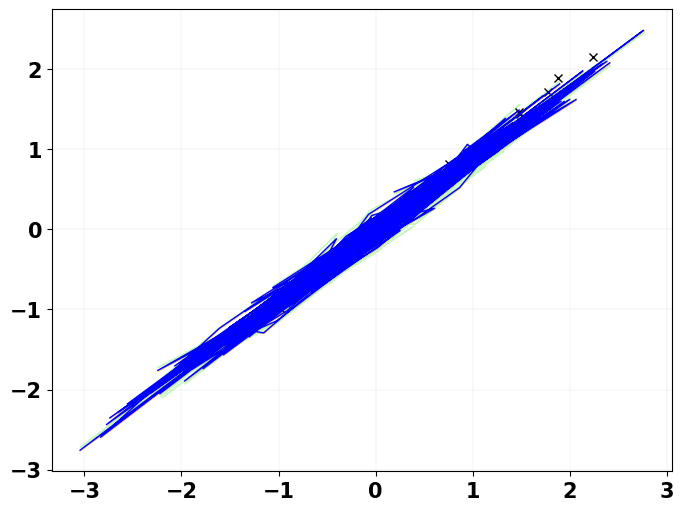

In [87]:
_ = delta.run(random.PRNGKey(1))

In [88]:
delta._params

{'prec_obs_loc': DeviceArray(400.00003, dtype=float32),
 'w_loc': DeviceArray([ 8.4479533e-02,  7.6183474e-01, -1.0738507e-03,
               1.1662306e+00, -1.1825948e-02], dtype=float32)}

In [89]:
map_posterior = delta._predictions['Y_mean'][0]
map_mse = np.mean(np.square(map_posterior - data.test[1]))
map_mse

1.5444316

In [91]:
hmc = BasicHMCExperiment(bnn, data, init_params={'w': delta._params['w_loc']},
                         num_samples=400, num_warmup=300)

sample: 100%|██████████| 700/700 [00:04<00:00, 157.99it/s, 791 steps of size 7.32e-03. acc. prob=0.93] 



MCMC elapsed time: 6.591850996017456


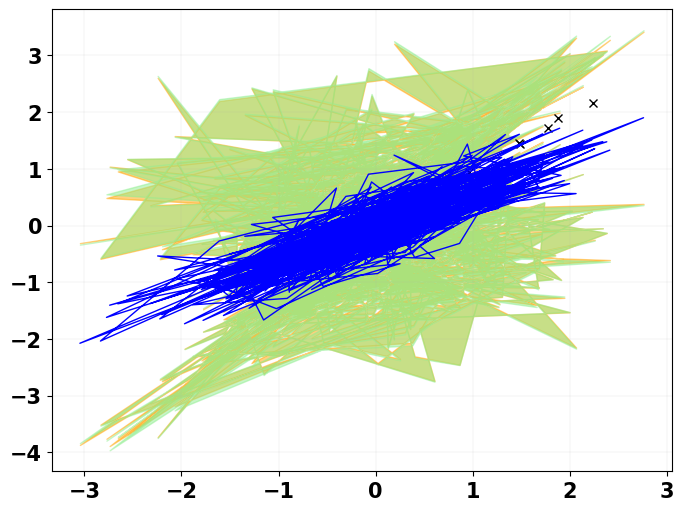

In [92]:
_ = hmc.run(random.PRNGKey(0))

In [93]:
hmc_mean_predictions = hmc._predictions['Y_mean'].mean(axis=0)
hmc_mse = np.mean(np.square(hmc_mean_predictions - data.test[1]))
hmc_mse

0.78141224

In [94]:
hmc._samples['w'][-5:]

DeviceArray([[ 1.9308871 ,  0.59039134,  0.16232468,  0.38973737,
              -0.06430176],
             [ 1.9201806 ,  0.58397585,  0.06849727,  0.3891214 ,
              -0.02651853],
             [ 0.70157844,  0.42874864, -0.05742479,  0.8673416 ,
               0.05950963],
             [ 1.0033038 ,  2.7077353 ,  0.11296564,  0.27288806,
              -0.05791593],
             [ 0.9569848 ,  0.36800757, -0.16398561,  0.75094986,
               0.11149071]], dtype=float32)